# Test Corr Models

In [1]:
import numpy as np
import pandas as pd
from copy import deepcopy
import yfinance as yf

import dynamic_correlations as CM
import backtesting as BT
import plots as IP
import data_download as dd

### Data 

In [2]:
# Define shares directly (tickers inferred from index)
shares = pd.Series({
    "AAPL": 10,
    "MSFT": 5,
    "NVDA": 8,
    "GOOGL": 6,
    "JPM": 7,
    "UNH": 4,
    "KO": -12,
    "PEP": 5,
    "BMW.DE": -3,     # short
    "NESN.SW": 0.2,   # fractional
    "NOVN.SW": 1.5,
    "ASML.AS": 2
})

# Download prices for the tickers in 'shares'
tickers = shares.index.tolist()
prices = dd.get_raw_prices(tickers, start="2022-01-01")

# Convert prices to base currency (e.g. CHF)
prices_converted = dd.convert_to_base(prices, base="CHF")

# Create portfolio with monetary positions
x_matrix = dd.create_portfolio(prices_converted, shares)

# Compute returns and summary stats
returns, mean_returns, covariance_matrix = dd.summary_statistics(x_matrix)

# Display
final_value = x_matrix.sum(axis=1).iloc[-1]
print(f"\nPortfolio final value in CHF: {final_value:.2f}")
print("\nSample of daily returns:\n", returns.head())
print("\nMean returns (daily, in CHF):\n", mean_returns)
print("\nCovariance matrix (in CHF):\n", covariance_matrix)


[currency detection] AAPL: USD
[currency detection] ASML.AS: EUR
[currency detection] BMW.DE: EUR
[currency detection] GOOGL: USD
[currency detection] JPM: USD
[currency detection] KO: USD
[currency detection] MSFT: USD
[currency detection] NESN.SW: CHF
[currency detection] NOVN.SW: CHF
[currency detection] NVDA: USD
[currency detection] PEP: USD
[currency detection] UNH: USD
[fx download] Downloading FX pairs: CHFEUR=X, CHFUSD=X
[conversion] AAPL: USD → CHF via CHFUSD=X
[conversion] ASML.AS: EUR → CHF via CHFEUR=X
[conversion] BMW.DE: EUR → CHF via CHFEUR=X
[conversion] GOOGL: USD → CHF via CHFUSD=X
[conversion] JPM: USD → CHF via CHFUSD=X
[conversion] KO: USD → CHF via CHFUSD=X
[conversion] MSFT: USD → CHF via CHFUSD=X
[conversion] NVDA: USD → CHF via CHFUSD=X
[conversion] PEP: USD → CHF via CHFUSD=X
[conversion] UNH: USD → CHF via CHFUSD=X

Portfolio final value in CHF: 8985.80

Sample of daily returns:
                 AAPL   ASML.AS    BMW.DE     GOOGL       JPM        KO  \
Date 

In [3]:
x_matrix.head()

,AAPL,ASML.AS,BMW.DE,GOOGL,JPM,KO,MSFT,NESN.SW,NOVN.SW,NVDA,PEP,UNH
Date,,,,,,,,,,,,
2022-01-03,1629.203385,1405.115070,-229.284607,789.596675,938.395609,-588.583331,1484.853865,23.019710,97.372513,219.371740,717.262038,1747.324217
2022-01-04,1619.735457,1365.095111,-236.608525,791.852592,980.756864,-602.579522,1469.562655,23.069589,97.542206,214.806053,723.304233,1719.636136
2022-01-05,1573.010908,1338.897954,-240.794360,753.781242,960.603751,-606.174200,1409.886775,22.446088,98.305859,201.973975,724.092213,1711.437103
2022-01-06,1548.744073,1319.233699,-241.675322,754.601397,972.059817,-603.759874,1400.547844,22.396207,98.911938,206.439353,725.191666,1643.512635
2022-01-07,1557.051127,1335.918440,-240.814400,753.880546,985.982071,-604.994997,1407.386333,22.171747,99.069523,200.491147,729.283120,1611.858821


In [29]:
missing_values = x_matrix.isnull().any().any()
print(f"Does x_matrix have missing values? {missing_values}")

Does x_matrix have missing values? False


In [30]:
# Run MA Correlation VaR
x_ma = deepcopy(x_matrix)
result_ma= CM.var_corr_moving_average(x_ma, window_size=20)

# Run RiskMetrics Correlation VaR
x_rm = deepcopy(x_matrix)
result_rm = CM.var_corr_ewma(x_rm)


In [31]:
result_ma.head()

,Returns,Volatility,VaR,VaR Monetary,VaR Violation
2022-01-31,0.023020,0.015867,0.036913,284.109195,False
2022-02-01,-0.001652,0.015833,0.036833,282.986931,False
2022-02-02,0.011148,0.015044,0.034999,271.765457,False
2022-02-03,-0.020259,0.015391,0.035805,272.259846,False
2022-02-04,0.004545,0.015449,0.035941,274.496026,False


In [32]:
result_rm.head()

,Returns,Volatility,VaR,VaR Monetary,VaR Violation
2022-01-04,-0.007860,0.013666,0.031792,259.616883,False
2022-01-05,-0.026606,0.014743,0.034298,272.584225,False
2022-01-06,-0.012441,0.014646,0.034072,267.334277,False
2022-01-07,0.001574,0.014202,0.033038,259.588831,False
2022-01-10,-0.008456,0.013921,0.032384,252.147784,False


In [33]:
# Apply volatility-based ES to the MA VaR result
result_ma = CM.es_correlation(result_ma, confidence_level=0.99)

# Same for RiskMetrics
result_rm = CM.es_correlation(result_rm, confidence_level=0.99)

In [34]:
result_ma.head()

,Returns,Volatility,VaR,VaR Monetary,VaR Violation,ES,ES Monetary
2022-01-31,0.023020,0.015867,0.036913,284.109195,False,0.042290,325.493824
2022-02-01,-0.001652,0.015833,0.036833,282.986931,False,0.042198,324.208086
2022-02-02,0.011148,0.015044,0.034999,271.765457,False,0.040097,311.352042
2022-02-03,-0.020259,0.015391,0.035805,272.259846,False,0.041021,311.918446
2022-02-04,0.004545,0.015449,0.035941,274.496026,False,0.041176,314.480358


In [35]:
result_rm.head()

,Returns,Volatility,VaR,VaR Monetary,VaR Violation,ES,ES Monetary
2022-01-04,-0.007860,0.013666,0.031792,259.616883,False,0.036423,297.433851
2022-01-05,-0.026606,0.014743,0.034298,272.584225,False,0.039294,312.290076
2022-01-06,-0.012441,0.014646,0.034072,267.334277,False,0.039035,306.275396
2022-01-07,0.001574,0.014202,0.033038,259.588831,False,0.037850,297.401713
2022-01-10,-0.008456,0.013921,0.032384,252.147784,False,0.037101,288.876770



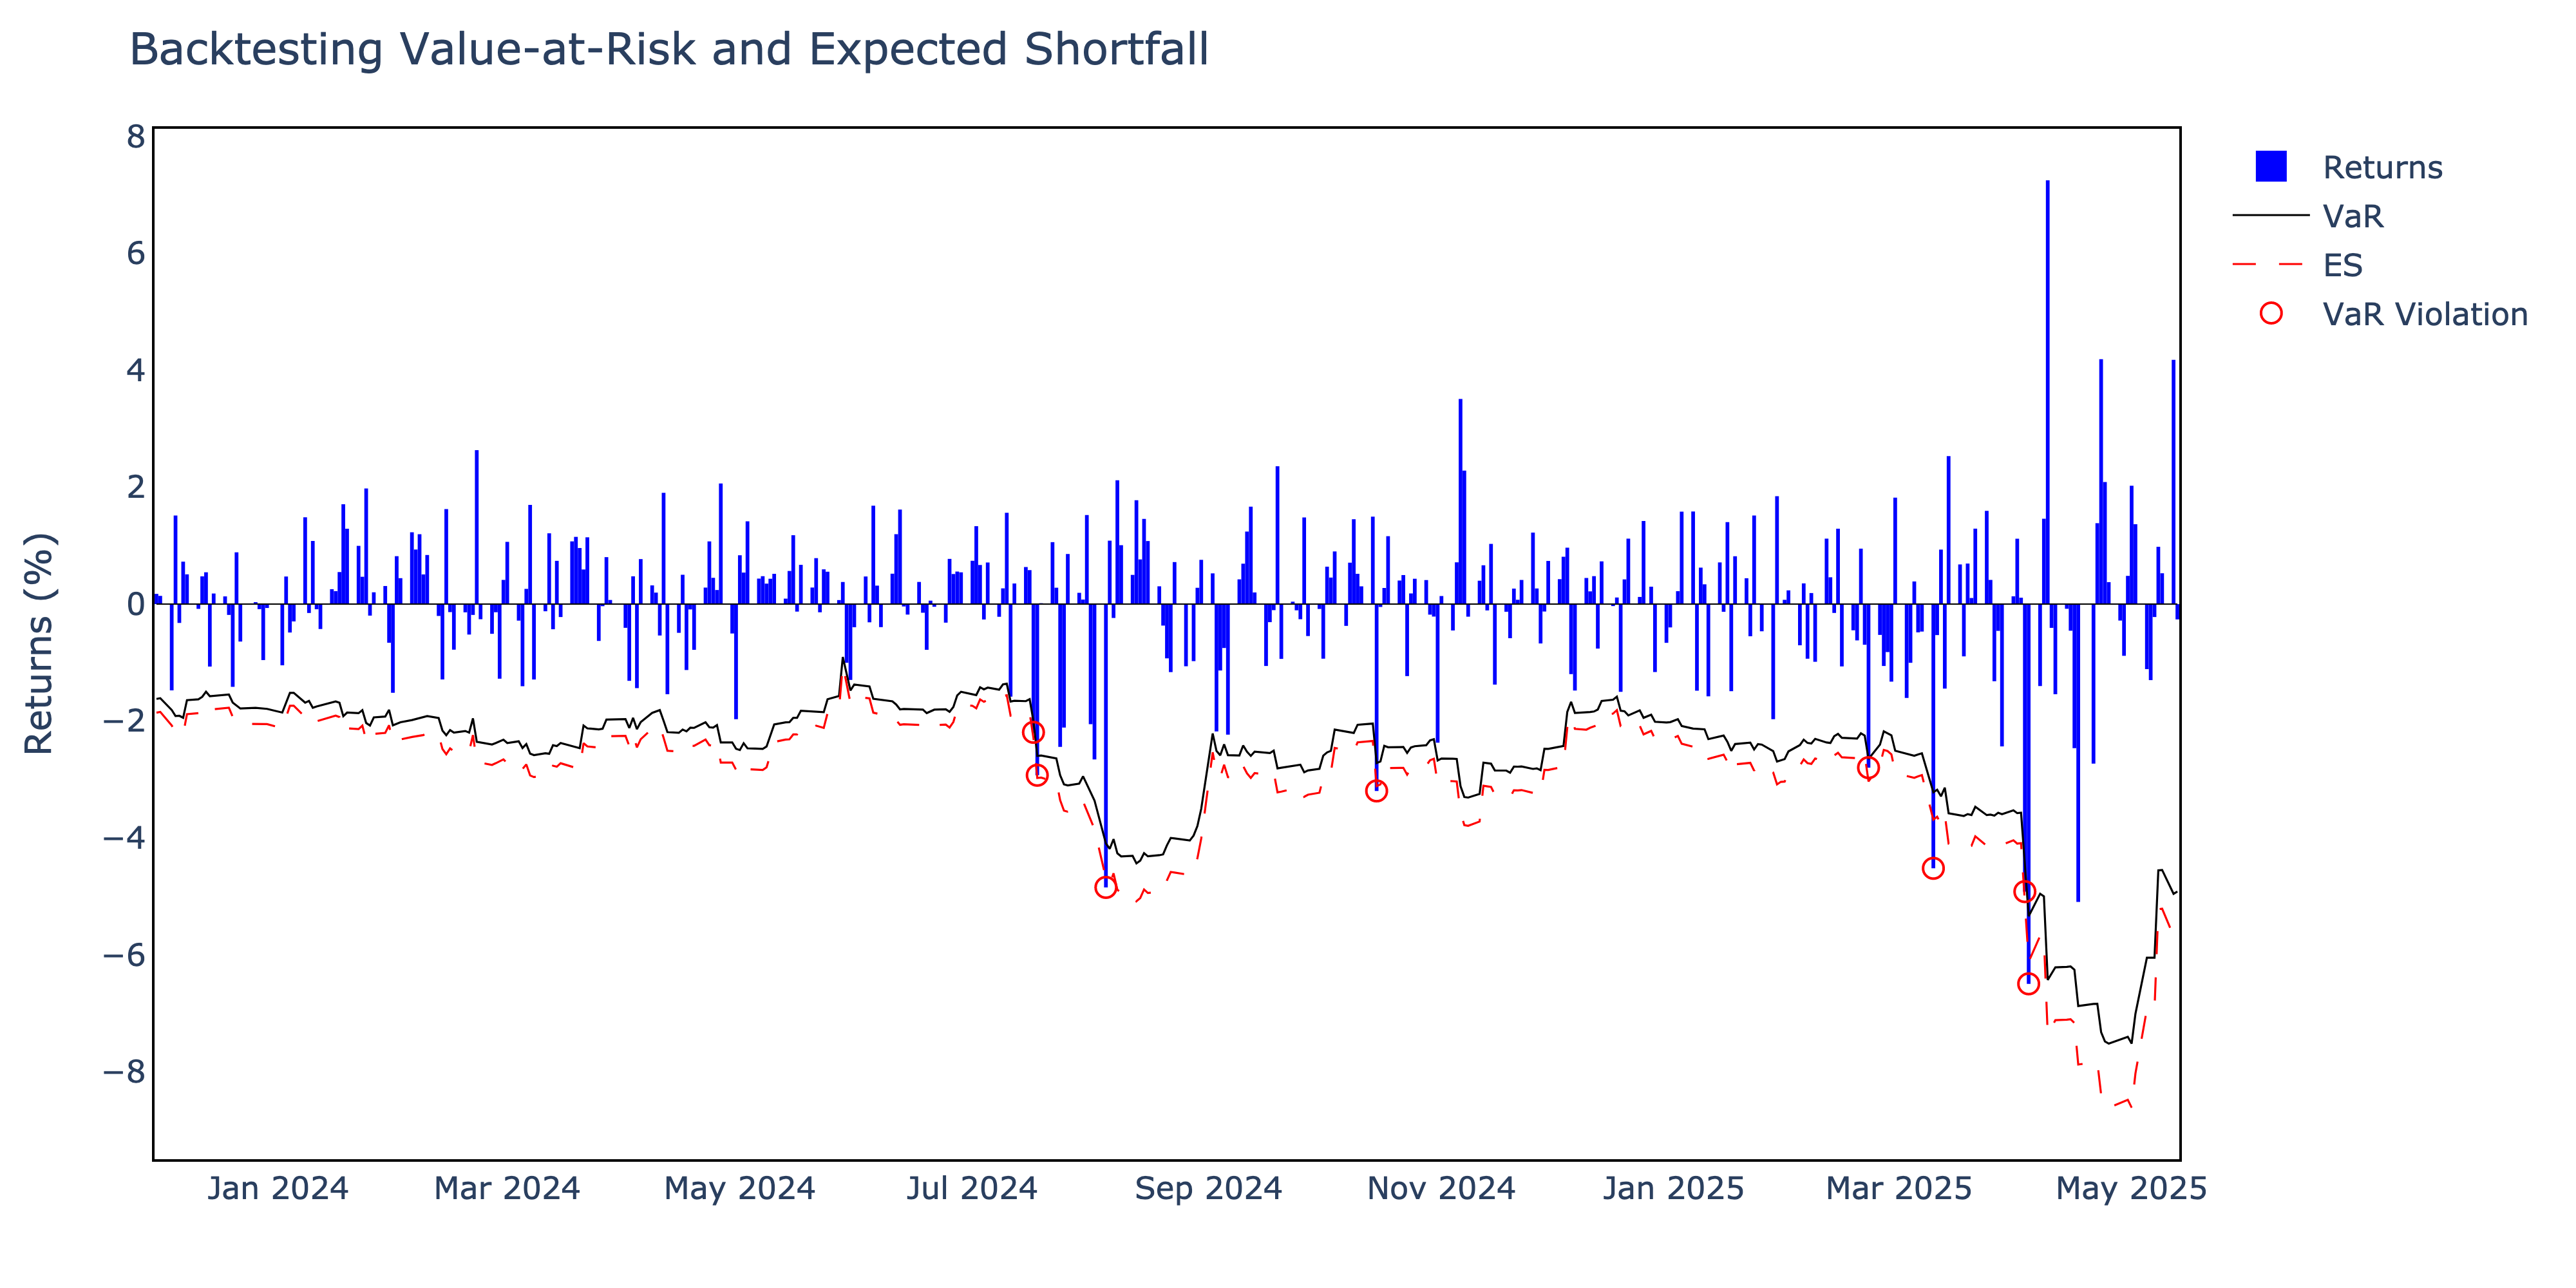


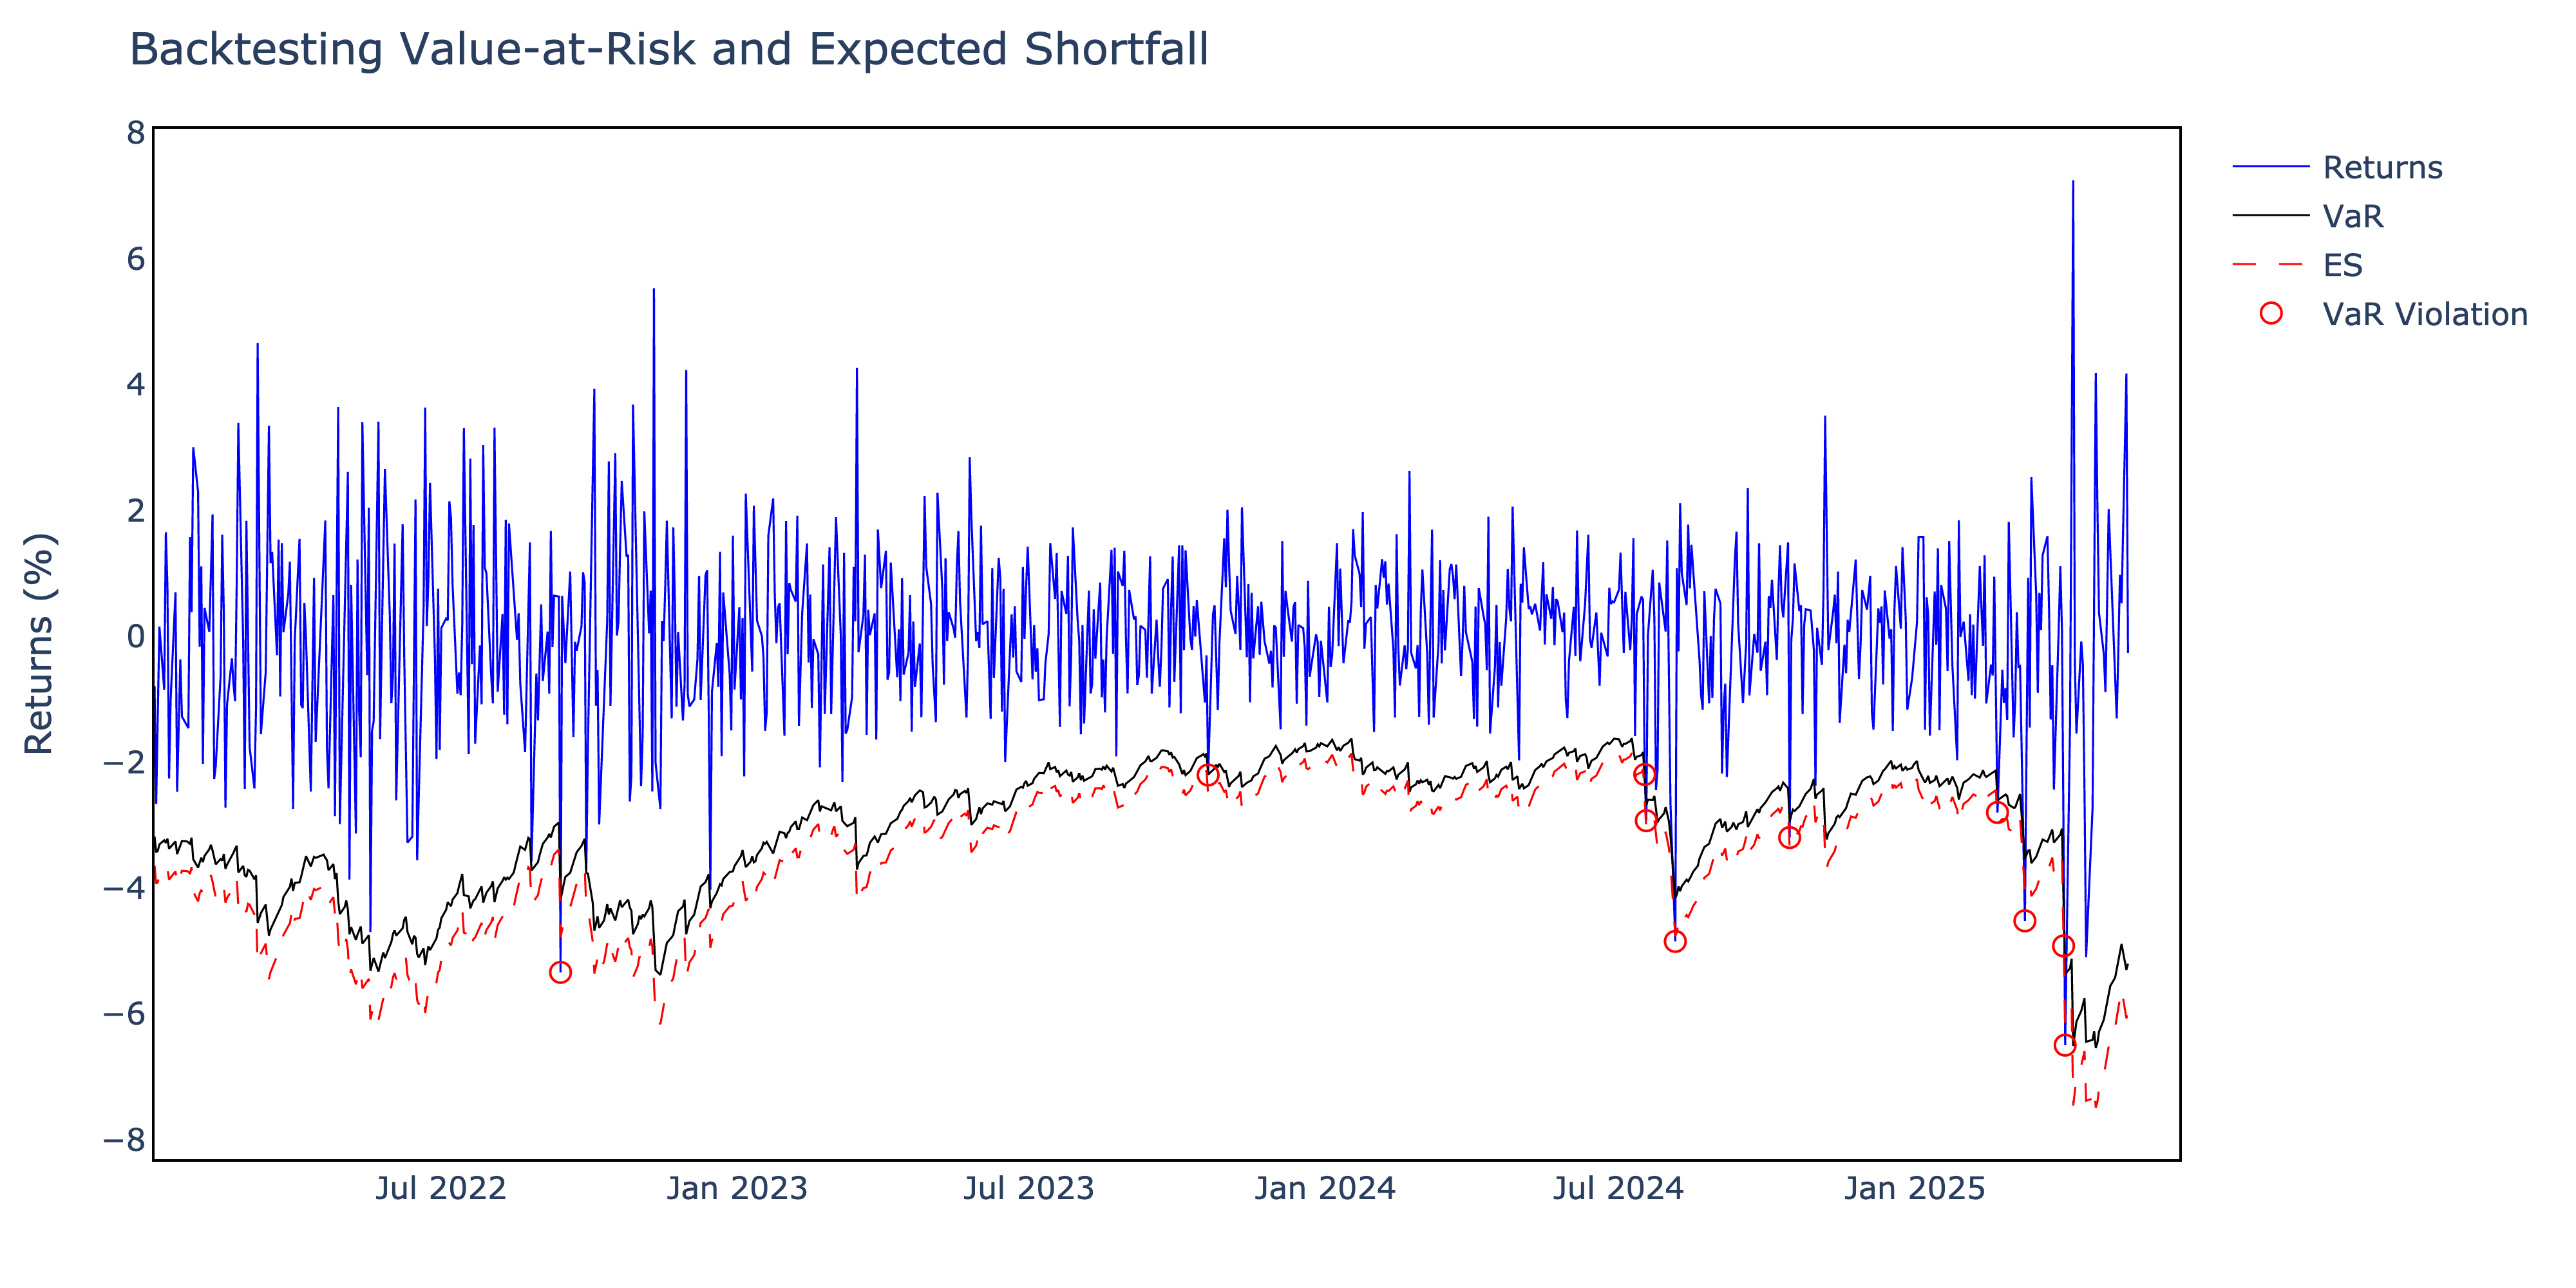

In [36]:
# Plot MA model results
fig_ma_es = IP.plot_backtest(result_ma, subset=("2023-11-30", "2025-11-30"), interactive=False)

# Plot RiskMetrics model results
fig_rm_es = IP.plot_backtest(result_rm, interactive=False)


In [37]:
violations_ma, rate_ma = BT.count_violations(result_ma)

print("== MA Correlation VaR Backtest ==")
print(f"Total Violations: {violations_ma}")
print(f"Violation Rate: {100*rate_ma:.2f}%")

== MA Correlation VaR Backtest ==
Total Violations: 11
Violation Rate: 1.30%


In [38]:
violations_rm, rate_rm = BT.count_violations(result_rm)

print("== RiskMetrics Correlation VaR Backtest ==")
print(f"Total Violations: {violations_rm}")
print(f"Violation Rate: {100*rate_rm:.2f}%")

== RiskMetrics Correlation VaR Backtest ==
Total Violations: 10
Violation Rate: 1.15%


In [39]:
fig_ma_vol = IP.plot_volatility(result_ma["Volatility"])
fig_rm_vol = IP.plot_volatility(result_rm["Volatility"])

### Bakctesting 

In [40]:
# 1. Recompute monetary positions (already done)
x_rm = deepcopy(x_matrix)

# 2. Run RiskMetrics Correlation VaR
result_rm = CM.var_corr_ewma(x_rm)

# 3. Count violations
total_violations, violation_rate = BT.count_violations(result_rm)

# 4. Run Kupiec test
confidence_level = 0.99  # adjust if needed
kupiec_results = BT.kupiec_test(total_violations, len(result_rm), confidence_level)

# 5. Run Christoffersen test
christoffersen_results = BT.christoffersen_test(result_rm)

# 6. Joint test
joint_results = BT.joint_lr_test(
    LR_uc=kupiec_results["LR_uc"],
    LR_c=christoffersen_results["LR_c"]
)


In [41]:
print("=== VaR Backtesting Summary ===")
print(f"Total Violations: {total_violations}")
print(f"Violation Rate: {100*violation_rate:.2f}%")

print("\n-- Kupiec Test --")
for k, v in kupiec_results.items():
    print(f"{k}: {v}")

print("\n-- Christoffersen Test --")
for k, v in christoffersen_results.items():
    print(f"{k}: {v}")

print("\n-- Joint Test --")
for k, v in joint_results.items():
    print(f"{k}: {v}")


=== VaR Backtesting Summary ===
Total Violations: 10
Violation Rate: 1.15%

-- Kupiec Test --
LR_uc: 0.19638797167920075
p_value: 0.657652305272496
reject_null: False

-- Christoffersen Test --
LR_c: 8.41176636011295
p_value: 0.0037280027654277292
reject_null: True

-- Joint Test --
LR_total: 8.60815433179215
p_value: 0.01351335037001311
reject_null: True


In [42]:
# 1. Recompute monetary positions (already done)
x_rm = deepcopy(x_matrix)

# 2. Run RiskMetrics Correlation VaR
result_rm = CM.var_corr_ewma(x_rm)

# 3. Count violations
total_violations, violation_rate = BT.count_violations(result_ma)

# 4. Run Kupiec test
confidence_level = 0.99  # adjust if needed
kupiec_results = BT.kupiec_test(total_violations, len(result_ma), confidence_level)

# 5. Run Christoffersen test
christoffersen_results = BT.christoffersen_test(result_ma)

# 6. Joint test
joint_results = BT.joint_lr_test(
    LR_uc=kupiec_results["LR_uc"],
    LR_c=christoffersen_results["LR_c"]
)


In [43]:
print("=== VaR Backtesting Summary ===")
print(f"Total Violations: {total_violations}")
print(f"Violation Rate: {100*violation_rate:.2f}%")

print("\n-- Kupiec Test --")
for k, v in kupiec_results.items():
    print(f"{k}: {v}")

print("\n-- Christoffersen Test --")
for k, v in christoffersen_results.items():
    print(f"{k}: {v}")

print("\n-- Joint Test --")
for k, v in joint_results.items():
    print(f"{k}: {v}")


=== VaR Backtesting Summary ===
Total Violations: 11
Violation Rate: 1.30%

-- Kupiec Test --
LR_uc: 0.6916380083776801
p_value: 0.40560779157221605
reject_null: False

-- Christoffersen Test --
LR_c: 7.521141657738781
p_value: 0.006097902127466526
reject_null: True

-- Joint Test --
LR_total: 8.212779666116461
p_value: 0.01646711638403031
reject_null: True
